# Třída svítivosti

V tomto dokumentu dojde k vytvoření neuronové sítě pro rozpoznávání třídy svítivosti hvězd na základě jejich absolutní magnitudy a barevného indexu B-V. K tomu je třeba importovat následující knihovny a moduly:

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

## Příprava dat

K naučení neuronové sítě bude použit dataset dostupný přes [VizieR](https://vizier.u-strasbg.fr/viz-bin/VizieR-3?-source=V/137D/XHIP). Bylo vybráno pouze 579 hvězd reprezentujících všechny možné třídy svítivosti.

In [2]:
data = pd.read_csv("stars.csv")
data

,teff,mag,lum_class
0,3068,16.12,5
1,3042,16.60,5
2,2600,18.70,5
3,2800,16.65,5
4,1939,20.06,5
...,...,...,...
574,4700,1.62,3
575,4550,1.44,3
576,5000,1.65,3
577,4550,1.40,3


Z teploty `teff` nejdříve odvodíme barevný index B-V.

In [17]:
spect_classes = ["O", "B", "A", "F", "G", "K", "M", "L", "T"]
classes = ["0", "I", "II", "III", "IV", "V", "VI", "VII"]

data["bv"] = data["teff"].apply(lambda t: -3.684 * np.log10(t) + 14.551 if t < 9641 else 0.344 * np.log10(t)**2 - 3.402 * np.log10(t) + 8.037)

data

,teff,mag,lum_class,bv
0,11096,-5.910,1,-0.095656
1,3553,-11.030,0,1.470607
2,5000,1.650,3,0.923995
3,4250,1.690,3,1.184015
4,5200,0.520,3,0.861244
...,...,...,...,...
574,10012,0.013,5,-0.067338
575,16700,-5.888,1,-0.194702
576,4400,0.870,3,1.128520
577,5200,1.150,3,0.861244


Následně sestrojíme graf zobrazující tyto veličiny:

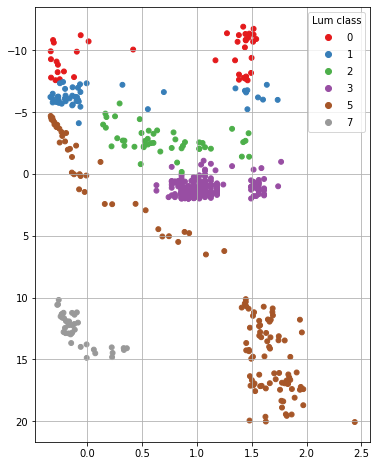

In [35]:
plt.rcParams["figure.figsize"] = (6,8)
plt.grid()
plt.gca().invert_yaxis()
sc = plt.scatter(data["bv"], data["mag"], c=data["lum_class"], cmap="Set1", s=24)

handles, labels = sc.legend_elements(prop="colors")
legend = plt.legend(handles, labels, title="Lum class")

Jednotlivé třídy svítivosti jsou zřetelně odděleny a jejich rozmístění odpovídá [Hertzsprungovu–Russellovu diagramu](https://cs.wikipedia.org/wiki/Hertzsprung%C5%AFv%E2%80%93Russell%C5%AFv_diagram).

## Sestrojení neuronové sítě

Nejdříve definujeme architekturu sítě.

In [5]:
nn = Sequential([
    Dense(16, input_shape=(2,), activation="relu"),
    Dense(len(classes), activation="softmax")
])

nn.compile(optimizer="rmsprop", loss="mse")
nn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                48        
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
Total params: 184
Trainable params: 184
Non-trainable params: 0
_________________________________________________________________


Následně rozdělíme námi připravená data na trénovací (80 %) a testovací (20 %).

In [6]:
data = data.sample(frac=1)  # Shuffle
data = data.reset_index(drop=True)

test_size = round(0.1 * data.shape[0])

x = data[["bv", "mag"]].to_numpy()
x_train, x_test = x[test_size:], x[:test_size]

y = np.zeros((data.shape[0], len(classes)))

for i, item in data.iterrows():
    #y[i,classes.index(item["lum_class"])] = 1
    y[i,int(item["lum_class"])] = 1
    
y_train, y_test = y[test_size:], y[:test_size]

x_train.shape, x_test.shape

((521, 2), (58, 2))

Síť naučíme z trénovacích dat:

In [7]:
stop = EarlyStopping(monitor="loss", patience=20)
nn.fit(x_train, y_train, epochs=1000, callbacks=[stop])

Epoch 1/1000
17/17 [==============================] - 0s 1ms/step - loss: 0.1363
Epoch 2/1000
17/17 [==============================] - 0s 592us/step - loss: 0.1261
Epoch 3/1000
17/17 [==============================] - 0s 849us/step - loss: 0.1176
Epoch 4/1000
17/17 [==============================] - 0s 798us/step - loss: 0.1112
Epoch 5/1000
17/17 [==============================] - 0s 811us/step - loss: 0.1095
Epoch 6/1000
17/17 [==============================] - 0s 757us/step - loss: 0.0992
Epoch 7/1000
17/17 [==============================] - 0s 840us/step - loss: 0.0895
Epoch 8/1000
17/17 [==============================] - 0s 640us/step - loss: 0.0811
Epoch 9/1000
17/17 [==============================] - 0s 792us/step - loss: 0.0804
Epoch 10/1000
17/17 [==============================] - 0s 904us/step - loss: 0.0737
Epoch 11/1000
17/17 [==============================] - 0s 704us/step - loss: 0.0664
Epoch 12/1000
17/17 [==============================] - 0s 858us/step - loss: 0.0599
Epo

17/17 [==============================] - 0s 600us/step - loss: 0.0110
Epoch 99/1000
17/17 [==============================] - 0s 663us/step - loss: 0.0129
Epoch 100/1000
17/17 [==============================] - 0s 654us/step - loss: 0.0117
Epoch 101/1000
17/17 [==============================] - 0s 551us/step - loss: 0.0140
Epoch 102/1000
17/17 [==============================] - 0s 512us/step - loss: 0.0131
Epoch 103/1000
17/17 [==============================] - 0s 687us/step - loss: 0.0111
Epoch 104/1000
17/17 [==============================] - 0s 621us/step - loss: 0.0120
Epoch 105/1000
17/17 [==============================] - 0s 447us/step - loss: 0.0117
Epoch 106/1000
17/17 [==============================] - 0s 685us/step - loss: 0.0130
Epoch 107/1000
17/17 [==============================] - 0s 780us/step - loss: 0.0117
Epoch 108/1000
17/17 [==============================] - 0s 544us/step - loss: 0.0125
Epoch 109/1000
17/17 [==============================] - 0s 514us/step - loss: 0.0

17/17 [==============================] - 0s 446us/step - loss: 0.0057
Epoch 195/1000
17/17 [==============================] - 0s 469us/step - loss: 0.0077
Epoch 196/1000
17/17 [==============================] - 0s 458us/step - loss: 0.0069
Epoch 197/1000
17/17 [==============================] - 0s 471us/step - loss: 0.0055
Epoch 198/1000
17/17 [==============================] - 0s 504us/step - loss: 0.0065
Epoch 199/1000
17/17 [==============================] - 0s 833us/step - loss: 0.0063
Epoch 200/1000
17/17 [==============================] - 0s 453us/step - loss: 0.0063
Epoch 201/1000
17/17 [==============================] - 0s 687us/step - loss: 0.0063
Epoch 202/1000
17/17 [==============================] - 0s 871us/step - loss: 0.0074
Epoch 203/1000
17/17 [==============================] - 0s 676us/step - loss: 0.0063
Epoch 204/1000
17/17 [==============================] - 0s 455us/step - loss: 0.0067
Epoch 205/1000
17/17 [==============================] - 0s 450us/step - loss: 0.

17/17 [==============================] - 0s 427us/step - loss: 0.0042
Epoch 291/1000
17/17 [==============================] - 0s 437us/step - loss: 0.0063
Epoch 292/1000
17/17 [==============================] - 0s 494us/step - loss: 0.0046
Epoch 293/1000
17/17 [==============================] - 0s 486us/step - loss: 0.0046
Epoch 294/1000
17/17 [==============================] - 0s 515us/step - loss: 0.0046
Epoch 295/1000
17/17 [==============================] - 0s 456us/step - loss: 0.0044
Epoch 296/1000
17/17 [==============================] - 0s 449us/step - loss: 0.0052
Epoch 297/1000
17/17 [==============================] - 0s 438us/step - loss: 0.0041
Epoch 298/1000
17/17 [==============================] - 0s 504us/step - loss: 0.0054
Epoch 299/1000
17/17 [==============================] - 0s 863us/step - loss: 0.0048
Epoch 300/1000
17/17 [==============================] - 0s 520us/step - loss: 0.0041
Epoch 301/1000
17/17 [==============================] - 0s 645us/step - loss: 0.

17/17 [==============================] - 0s 500us/step - loss: 0.0051
Epoch 387/1000
17/17 [==============================] - 0s 704us/step - loss: 0.0031
Epoch 388/1000
17/17 [==============================] - 0s 663us/step - loss: 0.0031
Epoch 389/1000
17/17 [==============================] - 0s 450us/step - loss: 0.0032
Epoch 390/1000
17/17 [==============================] - 0s 640us/step - loss: 0.0041
Epoch 391/1000
17/17 [==============================] - 0s 700us/step - loss: 0.0031
Epoch 392/1000
17/17 [==============================] - 0s 563us/step - loss: 0.0030
Epoch 393/1000
17/17 [==============================] - 0s 575us/step - loss: 0.0031
Epoch 394/1000
17/17 [==============================] - 0s 693us/step - loss: 0.0038
Epoch 395/1000
17/17 [==============================] - 0s 601us/step - loss: 0.0034
Epoch 396/1000
17/17 [==============================] - 0s 460us/step - loss: 0.0034
Epoch 397/1000
17/17 [==============================] - 0s 714us/step - loss: 0.

17/17 [==============================] - 0s 456us/step - loss: 0.0037
Epoch 483/1000
17/17 [==============================] - 0s 602us/step - loss: 0.0030
Epoch 484/1000
17/17 [==============================] - 0s 727us/step - loss: 0.0027
Epoch 485/1000
17/17 [==============================] - 0s 709us/step - loss: 0.0023
Epoch 486/1000
17/17 [==============================] - 0s 498us/step - loss: 0.0032
Epoch 487/1000
17/17 [==============================] - 0s 762us/step - loss: 0.0024
Epoch 488/1000
17/17 [==============================] - 0s 819us/step - loss: 0.0027
Epoch 489/1000
17/17 [==============================] - 0s 1ms/step - loss: 0.0027
Epoch 490/1000
17/17 [==============================] - 0s 716us/step - loss: 0.0029
Epoch 491/1000
17/17 [==============================] - 0s 470us/step - loss: 0.0035
Epoch 492/1000
17/17 [==============================] - 0s 548us/step - loss: 0.0033
Epoch 493/1000
17/17 [==============================] - 0s 574us/step - loss: 0.00

17/17 [==============================] - 0s 805us/step - loss: 0.0022
Epoch 579/1000
17/17 [==============================] - 0s 823us/step - loss: 0.0035
Epoch 580/1000
17/17 [==============================] - 0s 732us/step - loss: 0.0031
Epoch 581/1000
17/17 [==============================] - 0s 598us/step - loss: 0.0023
Epoch 582/1000
17/17 [==============================] - 0s 503us/step - loss: 0.0043
Epoch 583/1000
17/17 [==============================] - 0s 764us/step - loss: 0.0036
Epoch 584/1000
17/17 [==============================] - 0s 1ms/step - loss: 0.0030
Epoch 585/1000
17/17 [==============================] - 0s 835us/step - loss: 0.0025
Epoch 586/1000
17/17 [==============================] - 0s 504us/step - loss: 0.0037
Epoch 587/1000
17/17 [==============================] - 0s 475us/step - loss: 0.0028
Epoch 588/1000
17/17 [==============================] - 0s 522us/step - loss: 0.0025
Epoch 589/1000
17/17 [==============================] - 0s 1ms/step - loss: 0.0024

Nakonec otestujeme úspěšnost sítě.

In [8]:
result = nn.predict(x_test)
(result.argmax(axis=1) == y_test.argmax(axis=1)).sum() / len(result)

0.9827586206896551

Úspěšnost sítě se pohybuje mezi 95 % a 100 %, což je pro účely aplikace dostačující. Pro použití i mimo tento dokument vytvořenou a naučenou neuronovou síť uložíme do souboru.

In [9]:
nn.save("lum_class.h5")

x = load_model("lum_class.h5")
x.predict(np.array([[0.716, 5.32]])).argmax()

NameError: name 'load_model' is not defined

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np


tf.keras.backend.clear_session()

lum_class_nn = load_model("lum_class.h5")
global graph
global sess
graph = tf.get_default_graph()
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)


class NN:

    @staticmethod
    def predict_class(instance, input):
        x = NN.predict(instance, input).argmax()
        return x

    @staticmethod
    def predict(instance, input):
        with graph.as_default():
            tf.keras.backend.set_session(sess)
            return instance.predict(np.array([input]))[0]
        
NN.predict_class(lum_class_nn, [0.716, 5.32]), lum_class_nn.predict(np.array([[0.716, 5.32]])).argmax()